<a href="https://colab.research.google.com/github/DoggoSantini/coding/blob/main/digitrecogniser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports, Version Checking, and GPU Access

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version", tf.__version__)

Tensorflow version 2.12.0


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


Loading Data

In [3]:
def loadMNIST():
    # Use keras' inbuilt datasets module to load data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # x_train.shape = (60000, 28, 28)
    # y_train.shape = (60000, )
    # x_test.shape = (10000, 28, 28)
    # y_test.shape = (10000, )

    # Split 50:10 on train:validation, i.e. 50,000 datapoints for train, 10,000 for validation
    x_val, y_val = x_train[-10_000:, :, :], y_train[-10_000:]
    x_train, y_train = x_train[:-10_000, :, :], y_train[:-10_000]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [4]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = loadMNIST()

In [5]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((50000, 28, 28),
 (50000,),
 (10000, 28, 28),
 (10000,),
 (10000, 28, 28),
 (10000,))

Viewing the Data

In [6]:
idxs = tf.range(x_train.shape[0])
random_idxs = tf.random.shuffle(idxs)[:5] # pick 5 random indices
images = x_train[random_idxs, :, :]
labels = y_train[[random_idxs]]

<ipython-input-6-7fe0dc9e21ae>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  labels = y_train[[random_idxs]]


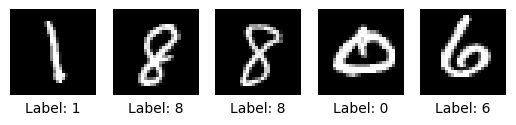

In [7]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    ax = axs[i]
    ax.imshow(images[i, :, :], cmap = 'gray')
    ax.axis('off')
    ax.text(0.5, -0.2, 'Label: ' + str(labels[i]), size = 10, ha = "center", transform = ax.transAxes)
plt.show()

Preprocess with TF

In [8]:
def preprocess(data):
    x_train, y_train, x_val, y_val, x_test, y_test = data

    x_train = tf.convert_to_tensor(x_train, dtype = tf.float32) / 255
    x_val   = tf.convert_to_tensor(x_val, dtype = tf.float32) / 255
    x_test  = tf.convert_to_tensor(x_test, dtype = tf.float32) / 255

    y_train = tf.one_hot(tf.convert_to_tensor(y_train), depth = 10)
    y_val   = tf.one_hot(tf.convert_to_tensor(y_val),  depth = 10)
    y_test  = tf.one_hot(tf.convert_to_tensor(y_test), depth = 10)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = preprocess((x_train, y_train, x_val, y_val, x_test, y_test))

Creating the Model with Keras

In [10]:
class CNN(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = (1, 1), padding = 'valid', activation = 'relu', input_shape = (None, 28, 28, 1))
        self.drop1 = tf.keras.layers.Dropout(rate = 0.5)
                
        self.conv2 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = (1, 1), padding = 'valid', activation = 'relu', input_shape = (None, 28, 28, 1))
        self.drop2 = tf.keras.layers.Dropout(rate = 0.5)

        self.flatten = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(units = 10, activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(units = 10, activation = 'softmax')

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, inputs.shape[1], inputs.shape[2], 1])
        
        x = self.conv1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.drop2(x)
        
        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)

        return x

In [11]:
model = CNN()
model.compile(optimizer = 'Adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
model.build(input_shape = [None, 28, 28])
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  30        
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           multiple                  84        
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  17290     
                                                                 
 dense_1 (Dense)             multiple                  110     

Fitting the Data

In [12]:
hist = model.fit(x_train, y_train, batch_size = 100, shuffle = True, validation_data = (x_val, y_val), epochs = 50)

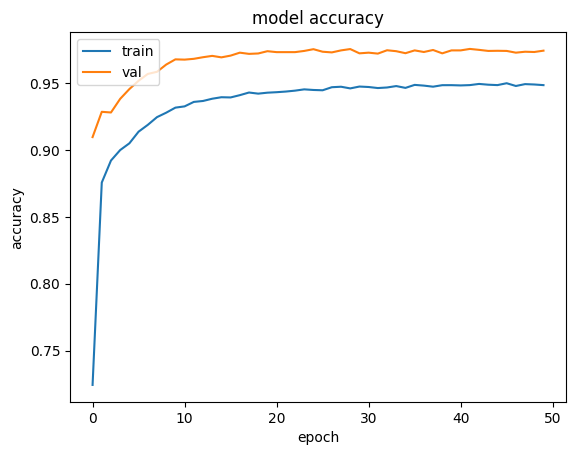

In [13]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Viewing Results

In [14]:
prob_test = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [15]:
pred_test = np.argmax(prob_test, axis = 1)
label_test = np.argmax(y_test, axis = 1)

In [17]:
idxs = tf.range(x_test.shape[0])
random_idxs = tf.random.shuffle(idxs)[:5] # pick 5 random indices
images = np.array(x_test)[random_idxs, :, :]
labels = label_test[[random_idxs]]
preds = pred_test[[random_idxs]]

<ipython-input-17-93f90f90cfc1>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  labels = label_test[[random_idxs]]
<ipython-input-17-93f90f90cfc1>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  preds = pred_test[[random_idxs]]


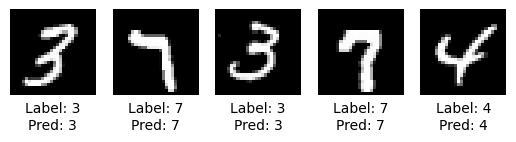

In [18]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    ax = axs[i]
    ax.imshow(images[i, :, :], cmap = 'gray')
    ax.axis('off')
    ax.text(0.5, -0.2, 'Label: ' + str(labels[i]), size = 10, ha = "center", transform = ax.transAxes)
    ax.text(0.5, -0.4, 'Pred: ' + str(preds[i]), size = 10, ha = "center", transform = ax.transAxes)
plt.show()

Finally Accuracy and Loss

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0869 - accuracy: 0.9747


In [20]:
print(f'Loss = {test_loss:.4f}, \nAccuracy: {test_acc*100:.2f}%')

Loss = 0.0869, 
Accuracy: 97.47%
